# Drowsiness Detection using Mediapipe in Python

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates

%matplotlib inline

**Get all the landmarks points for both eyes.**

In [2]:
# Landmark points corresponding to left eye
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs)) # flatten and remove duplicates
print("Left eye landmarks:", all_left_eye_idxs)

# Landmark points corresponding to right eye
all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs)) # flatten and remove duplicates
print("Right eye landmarks:", all_right_eye_idxs)

# Combined for plotting use - Landmark points for both eye
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)

Left eye landmarks: {384, 385, 386, 387, 388, 390, 263, 362, 398, 466, 373, 374, 249, 380, 381, 382}
Right eye landmarks: {160, 33, 161, 163, 133, 7, 173, 144, 145, 246, 153, 154, 155, 157, 158, 159}


In [3]:
# The chosen 12 points:   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]

all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

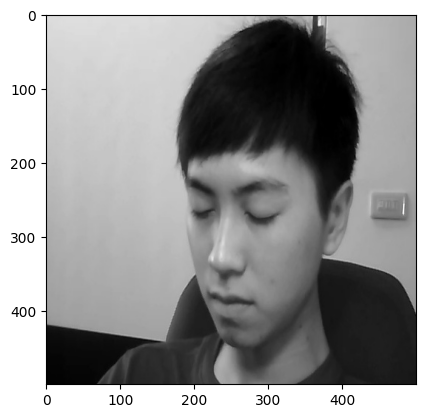

In [4]:
# Load an image. 

image = cv2.imread("/Users/daoxuanbac/Desktop/Python/SU23_DAP/DAP_Drowsiness/Data/drown/63.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB

image = np.ascontiguousarray(image)

imgH, imgW, _ = image.shape

plt.imshow(image);

In [5]:
# Running inference using static_image_mode 

with mp_facemesh.FaceMesh(
    static_image_mode=True,        # Default=False
    max_num_faces=1,               # Default=1
    refine_landmarks=False,        # Default=False
    min_detection_confidence=0.5,  # Default=0.5
    min_tracking_confidence= 0.5,  # Default=0.5
) as face_mesh:
    
    results = face_mesh.process(image)

print(bool(results.multi_face_landmarks)) # Indicates whether any detections are available or not.

True


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [6]:
# Get the first landmark point on the first detected face

landmark_0 = results.multi_face_landmarks[0].landmark[0]
print(landmark_0)

landmark_0_x = landmark_0.x * imgW
landmark_0_y = landmark_0.y * imgH
landmark_0_z = landmark_0.z * imgW # according to documentation

print("X:", landmark_0_x)
print("Y:", landmark_0_y)
print("Z:", landmark_0_z)

print()
print("Total Length of '.landmark':", len(results.multi_face_landmarks[0].landmark))

x: 0.47393027
y: 0.75518775
z: -0.022405533

X: 236.9651347398758
Y: 377.59387493133545
Z: -11.202766560018063

Total Length of '.landmark': 468


In [7]:
def plot(
    *,
    img_dt,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
    # For plotting Face Tessellation
    image_drawing_tool = img_dt 
    
     # For plotting all eye landmarks
    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks
    
    # For plotting chosen eye landmarks
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen

    # Initializing drawing utilities for plotting face mesh tessellation
    connections_drawing_spec = mp_drawing.DrawingSpec(
        thickness=ts_thickness, circle_radius=ts_circle_radius, color=(255, 255, 255)
    )

    # Initialize a matplotlib figure.
    fig = plt.figure(figsize=(20, 15))
    fig.set_facecolor("white")

    # Draw landmarks on face using the drawing utilities.
    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )

    # Get the object which holds the x, y and z coordinates for each landmark
    landmarks = face_landmarks.landmark

    # Iterate over all landmarks.
    # If the landmark_idx is present in either all_idxs or all_chosen_idxs,
    # get the denormalized coordinates and plot circles at those coordinates.

    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x, landmark.y, imgW, imgH)
            cv2.circle(image_eye_lmks, pred_cord, lmk_circle_radius, (255, 255, 255), -1)

        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x, landmark.y, imgW, imgH)
            cv2.circle(img_eye_lmks_chosen, pred_cord, lmk_circle_radius, (255, 255, 255), -1)


    # Plot post-processed images
    plt.subplot(1, 3, 1)
    plt.title("Face Mesh Tessellation", fontsize=18)
    plt.imshow(image_drawing_tool)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("All eye landmarks", fontsize=18)
    plt.imshow(image_eye_lmks)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(img_eye_lmks_chosen)
    plt.title("Chosen landmarks", fontsize=18)
    plt.axis("off")
#     plt.subplots_adjust(left=0.02, right=0.98, top=None, bottom=0.4, hspace=1.0)
#     plt.savefig(f'image_{name}.png', dpi=200.0, bbox_inches="tight")
    plt.show()
    plt.close()
    return

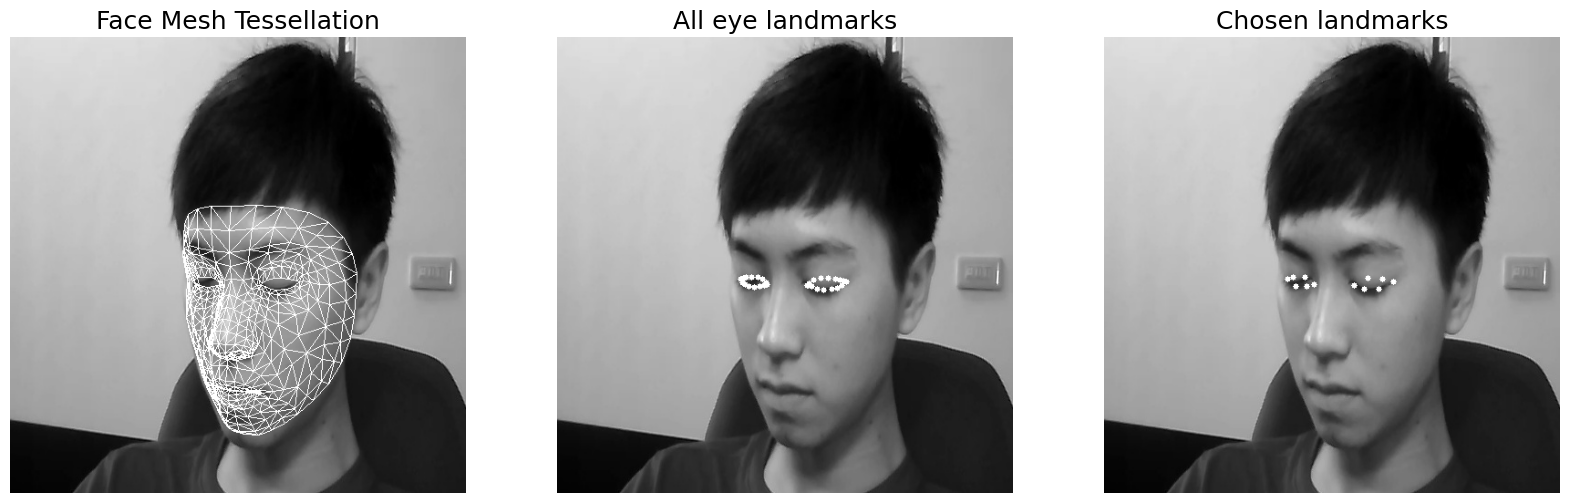

In [8]:
# If detections are available.
if results.multi_face_landmarks:
    
    # Iterate over detections of each face. Here, we have max_num_faces=1, 
    # so there will be at most 1 element in the 'results.multi_face_landmarks' list            
    # Only one iteration is performed.

    for face_id, face_landmarks in enumerate(results.multi_face_landmarks):    
        _ = plot(img_dt=image.copy(), face_landmarks=face_landmarks)

In [9]:
def distance(point_1, point_2):
    """Calculate l2-norm between two points"""
    dist = sum([(i - j) ** 2 for i, j in zip(point_1, point_2)]) ** 0.5
    return dist

In [10]:
def get_ear(landmarks, refer_idxs, frame_width, frame_height):
    """
    Calculate Eye Aspect Ratio for one eye.

    Args:
        landmarks: (list) Detected landmarks list
        refer_idxs: (list) Index positions of the chosen landmarks
                            in order P1, P2, P3, P4, P5, P6
        frame_width: (int) Width of captured frame
        frame_height: (int) Height of captured frame

    Returns:
        ear: (float) Eye aspect ratio
    """
    try:
        # Compute the euclidean distance between the horizontal
        coords_points = []
        for i in refer_idxs:
            lm = landmarks[i]
            coord = denormalize_coordinates(lm.x, lm.y, frame_width, frame_height)
            coords_points.append(coord)

        # Eye landmark (x, y)-coordinates
        P2_P6 = distance(coords_points[1], coords_points[5])
        P3_P5 = distance(coords_points[2], coords_points[4])
        P1_P4 = distance(coords_points[0], coords_points[3])

        # Compute the eye aspect ratio
        ear = (P2_P6 + P3_P5) / (2.0 * P1_P4)

    except:
        ear = 0.0
        coords_points = None

    return ear, coords_points

**Calculating `EAR` for the previously detected landmarks.**

In [11]:
landmarks = face_landmarks.landmark

In [12]:
left_ear, _  = get_ear(landmarks, chosen_left_eye_idxs, imgW, imgH)
right_ear, _ = get_ear(landmarks, chosen_right_eye_idxs, imgW, imgH)

EAR = (left_ear + right_ear) / 2

print("left_ear: ", left_ear)
print("right_ear:", right_ear)
print("Avg. EAR: ", EAR)

left_ear:  0.28196649744259805
right_ear: 0.34845370530362113
Avg. EAR:  0.31521010137310956


In [13]:
def calculate_avg_ear(landmarks, left_eye_idxs, right_eye_idxs, image_w, image_h):
    # Calculate Eye aspect ratio 
    left_ear,  _ = get_ear(landmarks, left_eye_idxs,  imgW, imgH)
    right_ear, _ = get_ear(landmarks, right_eye_idxs, imgW, imgH)

    Avg_EAR = (left_ear + right_ear) / 2
    return Avg_EAR

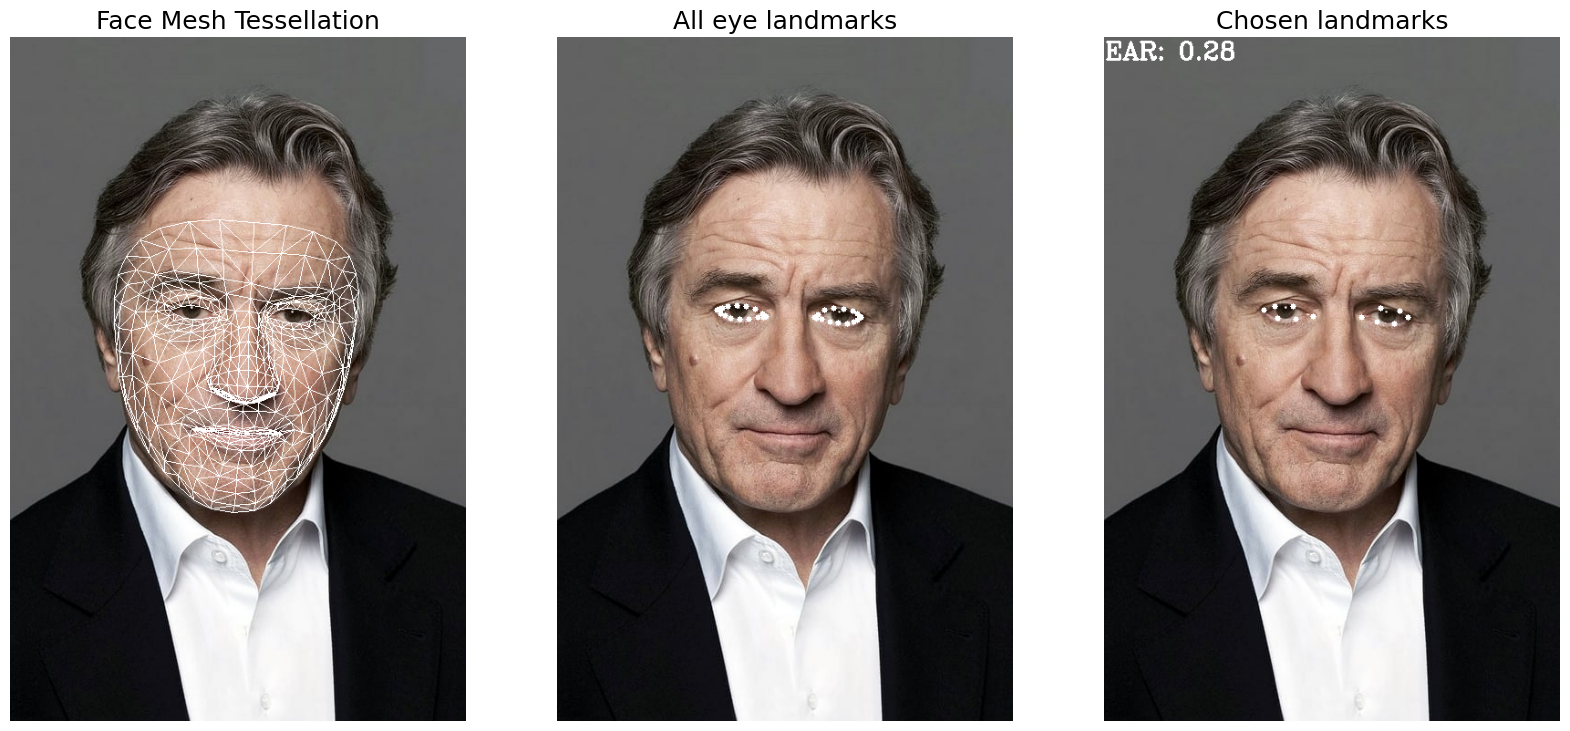

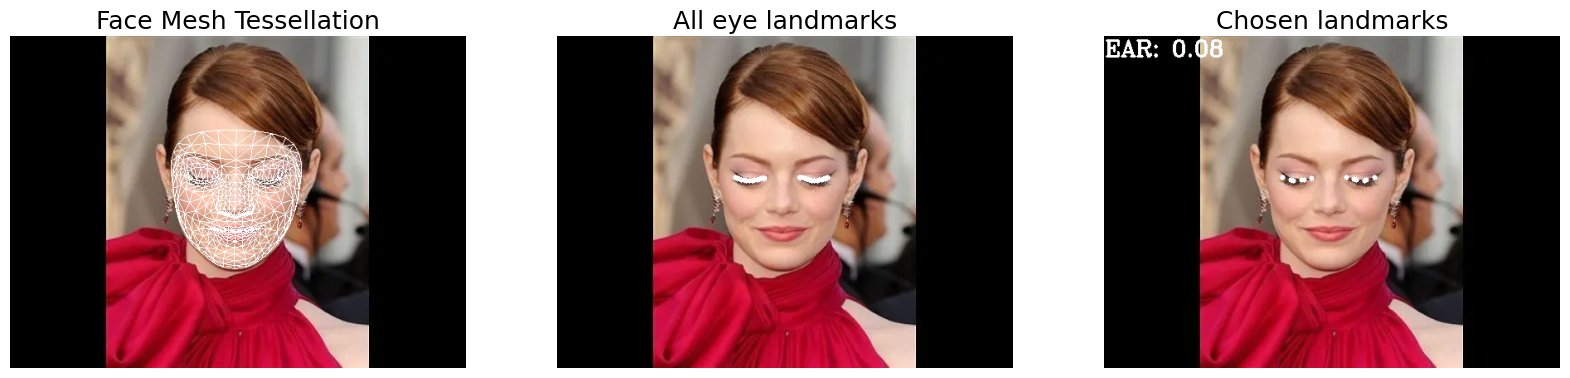

In [15]:
image_eyes_open  = cv2.imread("test-open-eyes.jpg")[:, :, ::-1]
image_eyes_close = cv2.imread("test-close-eyes.jpg")[:, :, ::-1]

for idx, image in enumerate([image_eyes_open, image_eyes_close]):
    
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape

    # Creating a copy of the original image for plotting the EAR value
    custom_chosen_lmk_image = image.copy()

    # Running inference using static_image_mode
    with mp_facemesh.FaceMesh(refine_landmarks=True) as face_mesh:
        results = face_mesh.process(image)

        # If detections are available.
        if results.multi_face_landmarks:

            # Iterate over detections of each face. Here, we have max_num_faces=1, so only one iteration is performed.
            for face_id, face_landmarks in enumerate(results.multi_face_landmarks):

                landmarks = face_landmarks.landmark
                EAR = calculate_avg_ear(landmarks, chosen_left_eye_idxs, chosen_right_eye_idxs, imgW, imgH)

                # Print the EAR value on the custom_chosen_lmk_image.
                cv2.putText(custom_chosen_lmk_image, f"EAR: {round(EAR, 2)}", (1, 24), 
                            cv2.FONT_HERSHEY_COMPLEX, 0.9, (255, 255, 255), 2
                )

                plot(img_dt=image.copy(),img_eye_lmks_chosen=custom_chosen_lmk_image, face_landmarks=face_landmarks,
                     ts_thickness=1, ts_circle_radius=3, lmk_circle_radius=3
                )